In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re

from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Unsupervised Learning Capstone

  The goal for this project is to exercise and apply unsupervised learning techniques. To do this we are going to use spacys' unsupervised neural networks and word vector library to generate document vectors out of word embeddings for each song in our data set. We will also generate term frequency - inverse document frequency vectors, and use latent semantic analysis on those vectors to reduce our feature space. Then we are going to use supervised classifiers on our vectors to classify which genre a lyric comes from, and see which vectors have the best performance. 

   Also we will use various clustering methods from sci kit learn to see if we can find any hiden data structure in our document vectors. We will also look at genre counts for each cluster to see if our clusters are picking up on the song genre, if they are not picking up on the genre labels then we will test the clusters for similarity using silhouette coeffecient.

In [2]:
df = pd.read_csv('lyrics.csv')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [3]:
df.shape

(362237, 6)

In [4]:
df.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

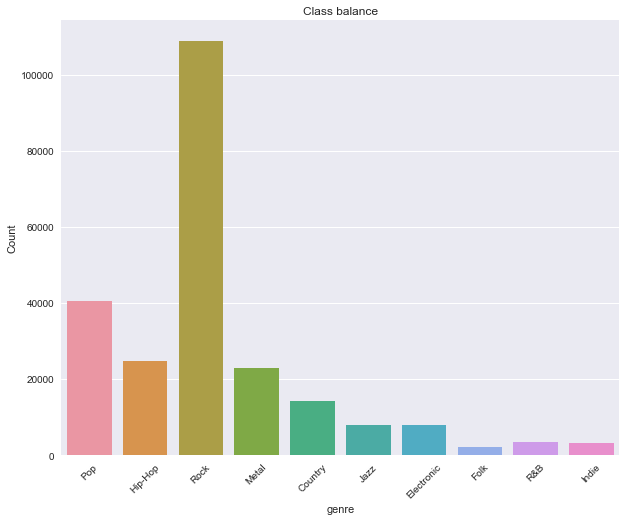

total observations: 236192


In [5]:
#Cleaning text, This should catch a lot of things spacys neural networks don't.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    # Get rid of \n.
    text = re.sub(r"\n", " ", text)
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    return text

df.dropna(inplace=True)
df.lyrics = df.lyrics.apply(text_cleaner)

#Droping all rows with null values, the 10,000 rows with out lyrics can't be used
#and the two rows with out song ids won't be missed
#Also droping rows where lyrics were missing, but not NAN, and Rows where genre is not available/other
df.dropna(inplace=True)
df.drop((df[df.genre == 'Not Available'].index),inplace=True, axis=0)
df.drop((df[df.genre == 'Other'].index),inplace=True, axis=0)
df.drop((df[df.lyrics.str.len() < 1].index), inplace=True, axis=0)

#Class balance is way off undersampling rock which represents about a third of our data set
#rock_index = df[df.genre == 'Rock'].index
#select rows to drop
#random_indices = np.random.choice(rock_index, 105000, replace=False)
#drop selected rows
#df.drop(random_indices, inplace=True, axis=0)

#for now reducing data set to 10,000 to save time
#df = df.sample(50000, random_state=42)
#df.reset_index(inplace=True, drop=True)
#df.drop('index', inplace=True, axis=1)

plt.figure(figsize=(10,8))
plt.title('Class balance')
sns.countplot(x="genre", data=df)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('total observations:', df.shape[0])

Language detection was out of the scope of this project so we're just doing a quick and dirty clean up
with pythons' langdetect package. Droping all rows where language was not english.

In [6]:
def detect_try(text):
    try:
        return detect(text)
    except:
        return 'error'

#Language column
df['language'] = df.lyrics.apply(detect_try)
print(df.language.value_counts())

#droping language column and rows that aren't english
df.drop((df[df.language != 'en'].index), inplace=True, axis=0)
df.drop('language', inplace=True, axis=1)

df.shape

en       216434
es         5772
de         2972
ro         1487
fr         1453
id         1427
it         1258
pt          759
error       665
sw          658
fi          442
nl          344
tr          312
no          287
tl          284
sv          268
hr          228
hu          172
so          159
pl          130
sq          111
cy          107
da           96
ca           92
af           81
lt           71
et           39
sl           32
vi           29
sk           14
cs            4
lv            3
ja            2
Name: language, dtype: int64


(216434, 6)

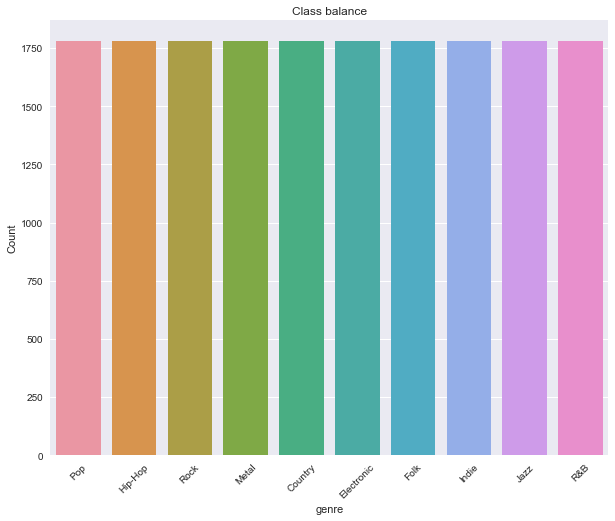

total observations: 17800
Per Class: 1780.0


In [7]:
#Fixing class balance with under sampling
indices_to_drop = []

for X in df.genre.unique():
    #get all indices for X genre
    indices_x = df[df.genre == X].index
    #how many to drop
    num = len(indices_x) - (df.genre.value_counts().min())
    #randomly select indeces to drop
    random_indices = list(np.random.choice(indices_x, num, replace=False))
    indices_to_drop += random_indices
    
df.drop(indices_to_drop, inplace=True, axis=0)
    
plt.figure(figsize=(10,8))
plt.title('Class balance')
sns.countplot(x="genre", data=df)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('total observations:', df.shape[0])
print('Per Class:', df.shape[0] / 10)

# Class Balance

Here we are using undersampling to balance our classes. One of the benefits of using undersampling is that we can reduce bias when compared to oversampling. Oversampling usually introduces a lot of bias by duplicating rows, which makes predictions easier because it's predicting a song it has seen before. By balancing our classes this way accuracy also becomes a strong metric. Here with ten equally balanced classes we know that a random guess has 10% accuracy. We also use stratification on our train test split which keeps this balance intact.

In [8]:
#removing chained assignment warning
pd.options.mode.chained_assignment = None

#change out put options
pd.set_option('display.max_colwidth', 300)

#method for getting Lemmas from our Spacy Docs for TFIDF
def doc2lemmas(nlpdoc):
    doc = []
    for token in nlpdoc:
        if token.lemma_ == '-PRON-':
            doc.append(token.text)
        elif token.is_punct:
            pass
        else:
            doc.append(token.lemma_.lower())
    doc = ' '.join(doc)
    return doc


#This spacy model has 1.1 million word embeddings that will help us generate our doc vectors.
#Get vectors
nlp = spacy.load('en_vectors_web_lg')
vectors = [] 

for doc in nlp.pipe(iter(df['lyrics']),batch_size=256):
    vectors.append(doc.vector)

#Get lemmas
nlp = spacy.load('en')
sentences = []

for doc in nlp.pipe(iter(df['lyrics']),batch_size=256):
    sentences.append(doc2lemmas(doc))

#column of lemmas
df['lemmas'] = sentences
df.lemmas.head()

##Create vector DF and concat to our original DF
vector_df = pd.DataFrame(vectors)
vector_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, vector_df], axis=1)

In [9]:
df.lyrics.head(2)

0    This is for my fans (Uhu, uhu) This is for my destiny (Uhu, uhu) This is for my fans (Uhu, uhu) This is for my future love (Uhu, uhu) This is for my best friend (Uhu, uhu) This is for my future children (Uhu, uhu) This is for my mother This is for the mother future You were my best friend and I ...
1    Baby I see you That look in your eyes Hips that keep shaking mysterious style exotically tempting familiar to me That Creole Sexy it's all over me So all my redbones get on the floor and all my yellow bones get on the floor and all my brown bones get on the floor Then you mix it up and call it C...
Name: lyrics, dtype: object

In [10]:
df.lemmas.head(2)

0    this be for my fan uhu uhu this be for my destiny uhu uhu this be for my fan uhu uhu this be for my future love uhu uhu this be for my good friend uhu uhu this be for my future child uhu uhu this be for my mother this be for the mother future You be my good friend and I love you You be always th...
1    baby I see you that look in your eye hips that keep shake mysterious style exotically tempt familiar to me that creole sexy it be all over me so all my redbone get on the floor and all my yellow bone get on the floor and all my brown bone get on the floor then you mix it up and call it creole cr...
Name: lemmas, dtype: object

In [11]:
#Document vectors based on word embeddings
df.loc[:,~df.columns.isin(['index', 'song', 'year', 'artist', 'genre', 'lyrics', 'lemmas'])].head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.044684,0.213144,-0.306956,-0.017865,0.081031,0.001832,0.032098,-0.136113,-0.010076,2.172359,...,-0.176646,0.020181,-0.025062,-0.035812,0.159360,-0.062664,0.058222,0.020022,0.031385,0.101767
1,-0.153793,0.167198,-0.226040,-0.042893,0.114116,0.050089,-0.022511,-0.150817,0.025760,2.057230,...,-0.154730,0.014669,-0.066197,-0.116918,0.028982,0.060921,-0.057644,-0.117327,0.092041,0.110347


In [12]:
def model_support(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train), ':word embedings train score')
    print(clf.score(X_test, y_test), ':word embedings test score\n')

def model_support2(clf, X_train_tfidf, y_train, X_test_tfidf, y_test):
    clf.fit(X_train_tfidf, y_train)
    print(clf.score(X_train_tfidf, y_train), ':tfidf w/ LSA train score')
    print(clf.score(X_test_tfidf, y_test), ':tfidf  w/ LSA test score')


#Transform lemmas into TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=2, stop_words='english',
    lowercase=True, use_idf=True,norm=u'l2',
    smooth_idf=True
)
X_tfidf = vectorizer.fit_transform(df.lemmas)

#Latent Semantic Analysis on TF-IDF
svd = TruncatedSVD(500)
X_tfidf = svd.fit_transform(X_tfidf)

#word2vec Data
X = df.loc[:,~df.columns.isin(['index', 'song', 'year', 'artist', 'genre', 'lyrics', 'lemmas'])]
y = df.loc[:,'genre']

#Split embeddings and tfidf with same random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=0.20, stratify=y, random_state=42)

In [13]:
svc = LinearSVC(C=1, random_state=42)

model_support(svc, X_train, y_train, X_test, y_test)

svc = LinearSVC(C=1, random_state=42)

model_support2(svc, X_train_tfidf, y_train, X_test_tfidf, y_test)

0.43293539325842695 :word embedings train score
0.3865168539325843 :word embedings test score

0.45484550561797754 :tfidf w/ LSA train score
0.3646067415730337 :tfidf  w/ LSA test score


In [14]:
gbc = GradientBoostingClassifier(max_depth=6, n_estimators=500, learning_rate=.1)

model_support(gbc, X_train, y_train, X_test, y_test)

gbc = GradientBoostingClassifier(max_depth=6, n_estimators=500, learning_rate=.1)

model_support2(gbc, X_train_tfidf, y_train, X_test_tfidf, y_test)

0.9971910112359551 :word embedings train score
0.399438202247191 :word embedings test score

0.996629213483146 :tfidf w/ LSA train score
0.3603932584269663 :tfidf  w/ LSA test score


In [15]:
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')

model_support(knn, X_train, y_train, X_test, y_test)

knn = KNeighborsClassifier(n_neighbors=9, weights='distance')

model_support2(knn, X_train_tfidf, y_train, X_test_tfidf, y_test)

0.9972612359550562 :word embedings train score
0.3146067415730337 :word embedings test score

0.9968398876404494 :tfidf w/ LSA train score
0.26292134831460673 :tfidf  w/ LSA test score


In [16]:
lr = LogisticRegression(C=5)

model_support(lr, X_train, y_train, X_test, y_test)

lr = LogisticRegression(C=5)

model_support2(lr, X_train_tfidf, y_train, X_test_tfidf, y_test)

0.4377808988764045 :word embedings train score
0.3943820224719101 :word embedings test score

0.4584269662921348 :tfidf w/ LSA train score
0.3634831460674157 :tfidf  w/ LSA test score


In [17]:
mlp = MLPClassifier(hidden_layer_sizes=(155,), max_iter=400)

model_support(mlp, X_train, y_train, X_test, y_test)

mlp = MLPClassifier(hidden_layer_sizes=(255,), max_iter=400)

model_support2(mlp, X_train_tfidf, y_train, X_test_tfidf, y_test)

0.6535112359550562 :word embedings train score
0.3929775280898876 :word embedings test score

0.9945926966292135 :tfidf w/ LSA train score
0.3643258426966292 :tfidf  w/ LSA test score


# Supervised Summary

Logistic regression and Multi Layer Perceptrons were very close. Logistic regression with word embeddings had the highest score on test. The accuracy is about 40%. Which is a bit dissapointing because it isn't practical in a real world application. However the model does have quiet a bit of predictive power. Recall that a random guess has 10% accuracy.

We could improve this model a couple of ways. We could try more cutting edge techniques, like word2vecs document vectors with paragraph vectors(PV-DM). Deep neural nets are also something i'm looking forward to learning, and LSTMs appear to be leading the way in this area of natural language processing. However, if we wanted to get this to work in a production or real world setting, I think we would likely need more relevant data, like beats per minute, and other audio related data. Predicting a song genre based on just the lyrics appears to be a pretty difficult task.

variance explained by each feature: [0.17938444 0.11023059]


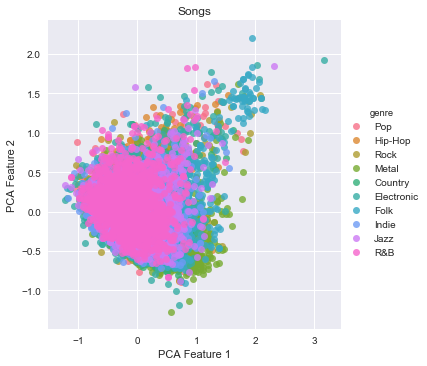

In [18]:
#Creating PCA data frame for visualizations
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = np.hstack((X_pca, y[:,None]))

X_pca = pd.DataFrame(X_pca, columns=['PCA Feature 1', 'PCA Feature 2', 'genre'])
print('variance explained by each feature:', pca.explained_variance_)

#plot data with seaborn
sns.lmplot(data=X_pca, x='PCA Feature 1', y='PCA Feature 2', hue='genre', fit_reg=False)
plt.title('Songs')
plt.show()

Visualizing our data in two dimensions through feature reduction, Principal Component Analysis. There doesn't appear to be any meaningful data structure in this space. lets check our clustering methods for silhouette score. Also doesn't look applicable to use a model like K-means.

In [27]:
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_score

bandwidth = estimate_bandwidth(X, quantile=.5, n_samples=1000, random_state=42)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_
print('number of clusters: {}'.format(len(np.unique(labels))))
print('silhouette score:', silhouette_score(X, labels, metric='euclidean'))

number of clusters: 2
silhouette score: 0.5791238645522929


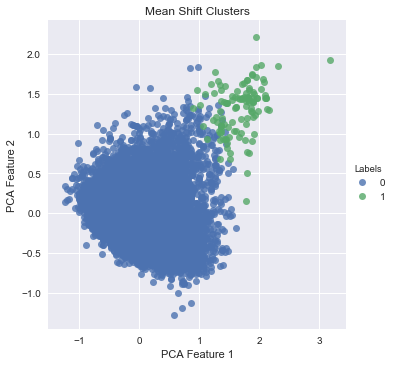

In [33]:
X_pca['Labels'] = labels

#plot data with seaborn
sns.lmplot(data=X_pca, x='PCA Feature 1', y='PCA Feature 2', hue='Labels', fit_reg=False)
plt.title('Mean Shift Clusters')
plt.show()

If there was any structure in our original visual, this is it. The silhouette score for this clustering model looks fair with 57. Lets take a look at the lyrics of this cluster.

In [32]:
X_pca['Lyrics'] = df.lyrics
X_pca.Lyrics[X_pca.Labels == 1].head(5)

367                                                                                                                                                                                                                                                                                 (Music by Nergal) Instrumental
504                                                                                                                                                                                                    50 Cent Ft. Snoop Dogg & Precious Paris - Remain Calm 50 Cent Ft. Snoop Dogg & Precious Paris - Remain Calm
605    Pour Hector et Pascale, Amber,Tamise, Fanette et sa famille FinistÃ¨re rÃªvÃ© le matin Ã l'est Ãle de RÃ© quatre Ã six Pique-nique souriant ouest Vent sud est revenant ouest sur ses fesses Ã midi prÃ¨s du cap Pour Fanette ce lundi vent d'ouest rÃ©crÃ© trois Ã cinq Puis fraises et champs cinq Ã ...
761    Come, they told me pa rum pum pum pum Our newborn King to see pa rum pum

## Mean Shift Summary

So it looks like this cluster is actually picking up on oddities. Things like instrumentals, bilingual songs, and written sounds. Our word vector library only contains english words, so it is not going to do a good job of finding a proper vector for these songs. That explains why they're in their own cluster. We could potentially use this cluster to do a better job of cleaning our data set.

In [25]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score

sc = SpectralClustering(n_clusters=10)
sc.fit(X)

predict = sc.fit_predict(X)

print('Comparing the assigned categories to the ones in the data:\n')
print(pd.crosstab(y, predict))
print('\nCounts for each clsuter label in order:', np.unique(predict, return_counts=True)[1])
print('\nAdjusted Rand Score', adjusted_rand_score(y, predict))

Comparing the assigned categories to the ones in the data:

col_0         0    1    2    3    4    5    6    7    8    9
genre                                                       
Country     108  282   39  215  228  232   70  159  174  273
Electronic  131  229   70  186  155  246  259  170  122  212
Folk        243  134   32  216  361  103  195   69  246  181
Hip-Hop      37   33  792   33   73   95   71  297  264   85
Indie       170  266   27  295  204  242   79  107  112  278
Jazz        106  205   60  186  201  222  131  196  216  257
Metal       542  110   19  238  430   70  150   28   51  142
Pop          81  272   59  212  119  383  104  236  105  209
R&B          54  189   64  149  126  391  123  348  112  224
Rock        176  226   49  256  198  228  116  173  142  216

Counts for each clsuter label in order: [1648 1946 1211 1986 2095 2212 1298 1783 1544 2077]

Adjusted Rand Score 0.041285541695129324


Spectral Clustering did not pick up on the genre structure as we had hoped. The rand score shows that our clusters are random, and show no similarities to our genre labels.